In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from rnndatasets import sequentialmnist as mnist

In [2]:
def orthogonal_regulariser(beta):
    def o_r(mat):
        if len(mat.get_shape()) != 2:
            return None
        cov = tf.matmul(mat, mat, transpose_b=True)  # careful which way
        eye = tf.constant(np.eye(mat.get_shape()[0].value))
        return tf.reduce_sum(tf.square(cov - eye)) * beta
    return o_r

In [3]:
data, targets = mnist.get_data('train', 50000)

In [4]:
def affine(input_var, new_size, scope=None):
    with tf.variable_scope(scope or 'affine'):
        in_size = input_var.get_shape()[1].value
        weights = tf.get_variable('weights', shape=[in_size, new_size])
        bias = tf.get_variable('bias', shape=[new_size], initializer=tf.constant_initializer(0.0))
        
        return tf.nn.bias_add(tf.matmul(input_var, weights), bias)

In [5]:
def deep_ff_net(input_var, depth, width, num_outputs, nonlinearity=tf.nn.relu):
    
    layer_in = input_var
    
    for i, size in enumerate([width] * depth):
        layer_in = affine(layer_in, size, 'layer_{}'.format(i))
        layer_in = nonlinearity(layer_in)
    
    out = affine(layer_in, num_outputs, 'output_layer')
    
    return out

In [6]:
def batch_iter(data, labels, batch_size):
    num_batches = data.shape[0] // batch_size
    
    for i in range(num_batches):
        dbatch = data[i*batch_size:(i+1)*batch_size, ...]
        lbatch = labels[i*batch_size:(i+1)*batch_size, ...]
        yield dbatch, lbatch

In [7]:
tf.reset_default_graph()

DEPTH = 1
WIDTH = 50

inputs = tf.placeholder(tf.float32, name='inputs', shape=[None, 784])
labels = tf.placeholder(tf.int32, name='labels', shape=[None])

with tf.variable_scope('deep_relu'):
    relu_out = deep_ff_net(inputs, DEPTH, WIDTH, 10)
    
    relu_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        relu_out, labels)
    relu_loss = tf.reduce_mean(relu_loss)
    
    relu_opt = tf.train.RMSPropOptimizer(0.01)
    relu_train = relu_opt.minimize(relu_loss)

In [8]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [9]:
data = data.reshape((-1, 784))

In [10]:
BATCH_SIZE = 50

losses = []

for epoch in range(10):
    epoch_loss = 0
    epoch_steps = 0
    for batch_data, batch_labels in batch_iter(data, targets, BATCH_SIZE):
        tloss, _ = sess.run([relu_loss, relu_train],
                            {inputs: batch_data,
                             labels: batch_labels})
        epoch_loss += tloss
        epoch_steps += 1
    losses.append(epoch_loss/epoch_steps)
    print('\r{}~Train xent: {}'.format(epoch+1, epoch_loss / epoch_steps), end='')

10~Train xent: 0.24388228059123504

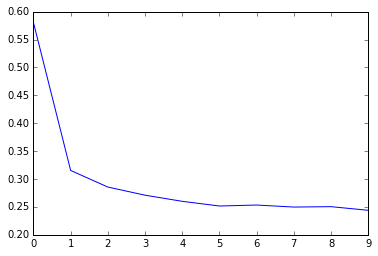

In [11]:
plt.plot(losses)